# Convolutional Neural Network Vignette Primary Document
Kaitlyn, Oscar, Nini, Johanna
12/6/2025



## Introduction 

Convolutional Neural Networks (CNNs) are a special type of neural networks designed for processing grid-structured data, particularly images. Unlike traditional fully-connected neural networks, CNNs use the spatial structure of images through localized connectivity and parameter sharing. This vignette explores CNN process and performance through implementation of a multi-class butterfly species classifier.

## Limitations of Fully Connected NNs

Traditional neural networks face significant challenges when processing image data. For a 128×128 pixel RGB image (which is what our butterfly image dataset consists of), the input dimensionality is 49,152 (128 × 128 × 3). A single fully-connected hidden layer with 256 neurons requires 12,583,936 parameters. This parameter explosion leads to computational inefficiency and increases the risk of overfitting. Additionally, fully-connected networks lack translation equivariance. Identical patterns appearing in different spatial locations have to be learned independently, requiring substantially more training data to achieve comparable performance to CNNs.

## CNN Architecture Principles

CNNs address these limitations through two fundamental design principles:

### Parameter Sharing:

Small learnable filters, called kernels, are applied across the entire input via convolution operations. The same filter weights are used at every spatial location, drastically reducing parameter count while enabling position-invariant feature detection.

### Hierarchical Feature Learning:

Stacked convolutional layers create hierarchical representations. Initial layers extract low-level features (edges, textures), intermediate layers identify mid-level patterns (shapes, object parts), and deep layers recognize high-level semantic concepts.

## CNN Layer Components

### Convolutional Layers

Convolutional layers apply learnable filters through discrete convolution operations. Each filter performs element-wise multiplication with the receptive field and sums the results, producing activation maps that indicate feature presence at different spatial locations.

### Activation Functions

Non-linear activation functions, typically ReLU (Rectified Linear Unit: f(x) = max(0,x)), are applied element-wise following convolution operations. Non-linearity is essential for learning complex mappings beyond linear transformations.

### Pooling Layers

Pooling operations perform spatial downsampling. Max pooling selects the maximum value within each pooling window, reducing spatial dimensions while retaining salient features. This provides computational efficiency, partial translation invariance, and regularization.

### Flatten Layers

Flatten operations reshape multi-dimensional feature maps into one-dimensional vectors, enabling transition from convolutional feature extraction to fully-connected classification layers.

### Fully-Connected Layers

Dense layers with full connectivity between consecutive layers aggregate extracted features for final classification. These layers function identically to traditional neural network layers.

### Dropout

Dropout applies stochastic regularization by randomly deactivating neurons during training with specified probability. This prevents co-adaptation of features and reduces overfitting.

### Output Layer

The final layer uses softmax activation to produce normalized probability distributions over classes.

## Dataset Description

The dataset comprises butterfly images spanning 75 species classes. The training set contains 6,499 images, split into 5,199 training samples and 1,300 validation samples (80/20 ratio). The test set contains 2,786 images. All images are resized to 128×128 pixels and processed in batches of 32. Stratified sampling ensures proportional class representation across training and validation splits. This is critical for maintaining class balance in multi-class problems with potentially uneven class distributions.

In [2]:
from IPython.display import HTML

display(HTML("""
<div style="display:flex;">
  <img src="../data/test/Image_1.jpg" width="200">
  <img src="../data/test/Image_2.jpg" width="200">
  <img src="../data/test/Image_3.jpg" width="200">
  <img src="../data/test/Image_4.jpg" width="200">
  <img src="../data/test/Image_5.jpg" width="200">
  <img src="../data/test/Image_6.jpg" width="200">
</div>
"""))


## Model Architecture

The implemented CNN follows a sequential architecture with variable depth controlled by the build_cnn() function:

### Input Layer:

128×128×3 (RGB images)

### Convolutional Blocks:

Each block contains a Conv2D layer with ReLU activation followed by a 2x2 max pooling. The number of filters doubles with each block (starting from 32).

### Flatten Layer:

Converts 3D feature maps to 1D vector

### Dense Layer:

256 units, ReLU activation 

### Dropout Layer: 

50% dropout rate

### Output Layer:

75 units (one per class), softmax activation

The model contains 6,535,307 trainable parameters.

## Depth Analysis

An experiment examining network depth trained models with 1, 2, 3, and 4 convolutional blocks:

### 1 Block:

Validation accuracy of 29.3%. Insufficient representational capacity for complex multi-class classification.The model struggles to learn meaningful hierarchical features with only one layer of abstraction.

### 2 Blocks:

Validation accuracy of 49.8%. Additional depth enables more discriminative feature learning. The second convolutional block allows the network to combine low-level features into more complex patterns.

### 3 Blocks:

Validation accuracy of 60.6%. Three-layer hierarchy provides adequate feature abstraction for this task, enabling the network to capture more sophisticated visual patterns that distinguish butterfly species.

### 4 Blocks:

Validation accuracy of 65.6%. Four convolutional blocks achieve the highest performance, demonstrating that additional depth contineus to benefit the model on this dataset. The deeper architecture can learn more nuanced hierarchical representation.

These results demonstrate that network depth directly impacts feature abstraction capability. However, excessive depth may lead to overfitting or training difficulties without sufficient data or regularization. Each additional convolutional block improves validation accuracy, showing that deeper networks can learn more sophisticated feature hierarchies for distinguishing between 75 butterfly species.

## Training Results

All model were trained for 10 epochs using the Adam optimizer and categorical cross-entropy loss. Training progression showed:

Epoch 1: 7.5% validation accuracy

Epoch 10: 65.6% validation accuracy

Training accuracy reached approximately 65.6% for the 4-block model by epoch 10, indicating some degree of overfitting. The training-validation accuracy gap suggests potential benefit from additional regularization or larger training datasets. This could be addressed through additional regularization techniques, data augmentation, or larger training datasets.

## Validation Predictions and Visualization

After training, the final model (4-block CNN) was evaluated on the validation set, achieving 65.6% accuracy. Sample predictions were visualized showing both correct and incorrect classifications, providing insight into model performance and common misclassification patterns.

# Conclusion

CNNs provide substantial advantages over fully-connected architectures for image classification tasks through parameter sharing and spatial structure exploitation. The butterfly classifier achieved 65.6% accuracy across 75 classes with the 4-block architecture, demonstrating effective feature learning from training data. Network depth proved critical for performance, with deeper architectures enabling more sophisticated feature hierarchies. Further improvements could be obtained through transfer learning, additional regularization techniques, or larger training datasets. 

# Code Summary

## Library Imports and Data Loading

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [4]:
train_df = pd.read_csv("../data/Training_set.csv")
test_df  = pd.read_csv("../data/Testing_set.csv")

Imports the necessary libraries for data manipulation (pandas, numpy), deep learning (tensorflow/keras), and image processing. Loads the training and testing CSV files that contained the image filenames and their species labels.

## Image Configuration and Data Preprocessing

In [7]:
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
train_df = train_df.rename(columns={"Image": "filename", "label": "class"})

train_df_split, val_df_split = train_test_split(
    train_df, test_size=0.2, stratify=train_df['class'], random_state=123
)

Sets the image dimensions to 128x128 pixels and batch size to 32 images per training iteration, and renamed the dataframe columns. Splits the training data set into 80% training and 20% validation subsets. The stratify parameter makes sure that each butterfly parameter maintains proportional representation in both splits, which is essential for balanced multi-class learning.

## Data Normalization and Generators

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

TRAIN_DIR = "../data/train"
TEST_DIR  = "../data/test"

num_classes = 75 #75 different butterfly species

train_gen = train_datagen.flow_from_dataframe(
    train_df_split,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df_split,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


Creates ImageDataGenerator objects that normalize pixel values from [0, 255] to [0, 1]. This process keeps the preprocessing simple with only normalization. Generators automatically load, preprocess, and batch images from directories during training.

## Variable Depth CNN Function

In [19]:
def build_cnn(num_conv_blocks=3, base_filters=32, dense_units=256):
    model = models.Sequential()
    model.add(layers.Conv2D(base_filters, (3,3), activation='relu', 
                            input_shape=(*IMAGE_SIZE, 3)))
    model.add(layers.MaxPooling2D((2,2)))
    
    filters = base_filters
    for i in range(num_conv_blocks - 1):
        filters *= 2
        model.add(layers.Conv2D(filters, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

Defines a function to construct CNNs with configurable depth. Allows experimentation with different numbers of convolutional blocks while maintaining consistent architecture patterns (doubling filters each block, same pooling strategy). The function builds the first convolutional block with the specified base filters, then iteratively adds additional blocks with progressively more filters (32 → 64 → 128 → 256 for a 4-block model). Enables systematic comparison of model complexity versus performance.

## Depth Experiment Training Loop

In [20]:
EPOCHS = 10
depths = [1, 2, 3, 4]
histories = {}

for d in depths:
    print(f"\nTraining model with {d} conv blocks...\n")
    model = build_cnn(num_conv_blocks=d)
    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
    histories[d] = history
    
    val_loss, val_acc = model.evaluate(val_gen)
    print(f"Validation accuracy for depth {d}: {val_acc:.4f}")


Training model with 1 conv blocks...

Epoch 1/10


/Users/oscarodonnell/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0190 - loss: 5.1257 - val_accuracy: 0.0331 - val_loss: 4.2870
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.0258 - loss: 4.2630 - val_accuracy: 0.0362 - val_loss: 4.2022
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.0279 - loss: 4.2036 - val_accuracy: 0.0408 - val_loss: 4.1227
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.0300 - loss: 4.1551 - val_accuracy: 0.0423 - val_loss: 3.9377
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0333 - loss: 4.0303 - val_accuracy: 0.0815 - val_loss: 3.8336
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0521 - loss: 3.8806 - val_accuracy: 0.1031 - val_loss: 3.6344
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.0700 - loss: 3.7606 - val_accuracy: 0.1262 - val_loss: 3.5325
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.1060 - loss: 3.5754 - val_accurac

In [29]:

val_acc_table = pd.DataFrame({
    "# of Conv Blocks": depths,
    "Validation Accuracy": [histories[d].history["val_accuracy"][-1] for d in depths]
})

print(val_acc_table)

   # of Conv Blocks  Validation Accuracy
0                 1             0.296154
1                 2             0.510769
2                 3             0.589231
3                 4             0.656923


Trains multiple models with 1, 2, 3, and 4 convolutional blocks to analyze the relationship between network depth and classification performance. Stores training history for each configuration and evaluates final validation accuracy. Results show validation accuracy increasing from 29% (1 block) to 51% (2 blocks) to 59% (3 blocks) to 66% (4 blocks), demonstrating the importance of depth for feature abstraction in this multi-class classification task.

## Validation Set Predictions

In [25]:
val_probs = model.predict(val_gen)
val_pred_indices = np.argmax(val_probs, axis=1)
index_to_class = {v: k for k, v in train_gen.class_indices.items()}
val_pred_labels = [index_to_class[i] for i in val_pred_indices]

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation accuracy: {val_acc:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6569 - loss: 1.4055
Validation accuracy: 0.6569


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('../data/train/ButterflyPredictions1.png')

plt.figure(figsize=(15, 10))  # Adjust these numbers to change size
plt.imshow(img)
plt.axis('off')
plt.show()

Generates predictions on the validation set by computing class probability distributions for all 1,300 validation images at once. Selects the highest probability class for each image using argmax, then maps numeric indices back to butterfly species names. Evaluates final model performance. The highest performing model had 4 convolutional blocks, achieving 66% accuracy on the validation set.

## Prediction Visualization

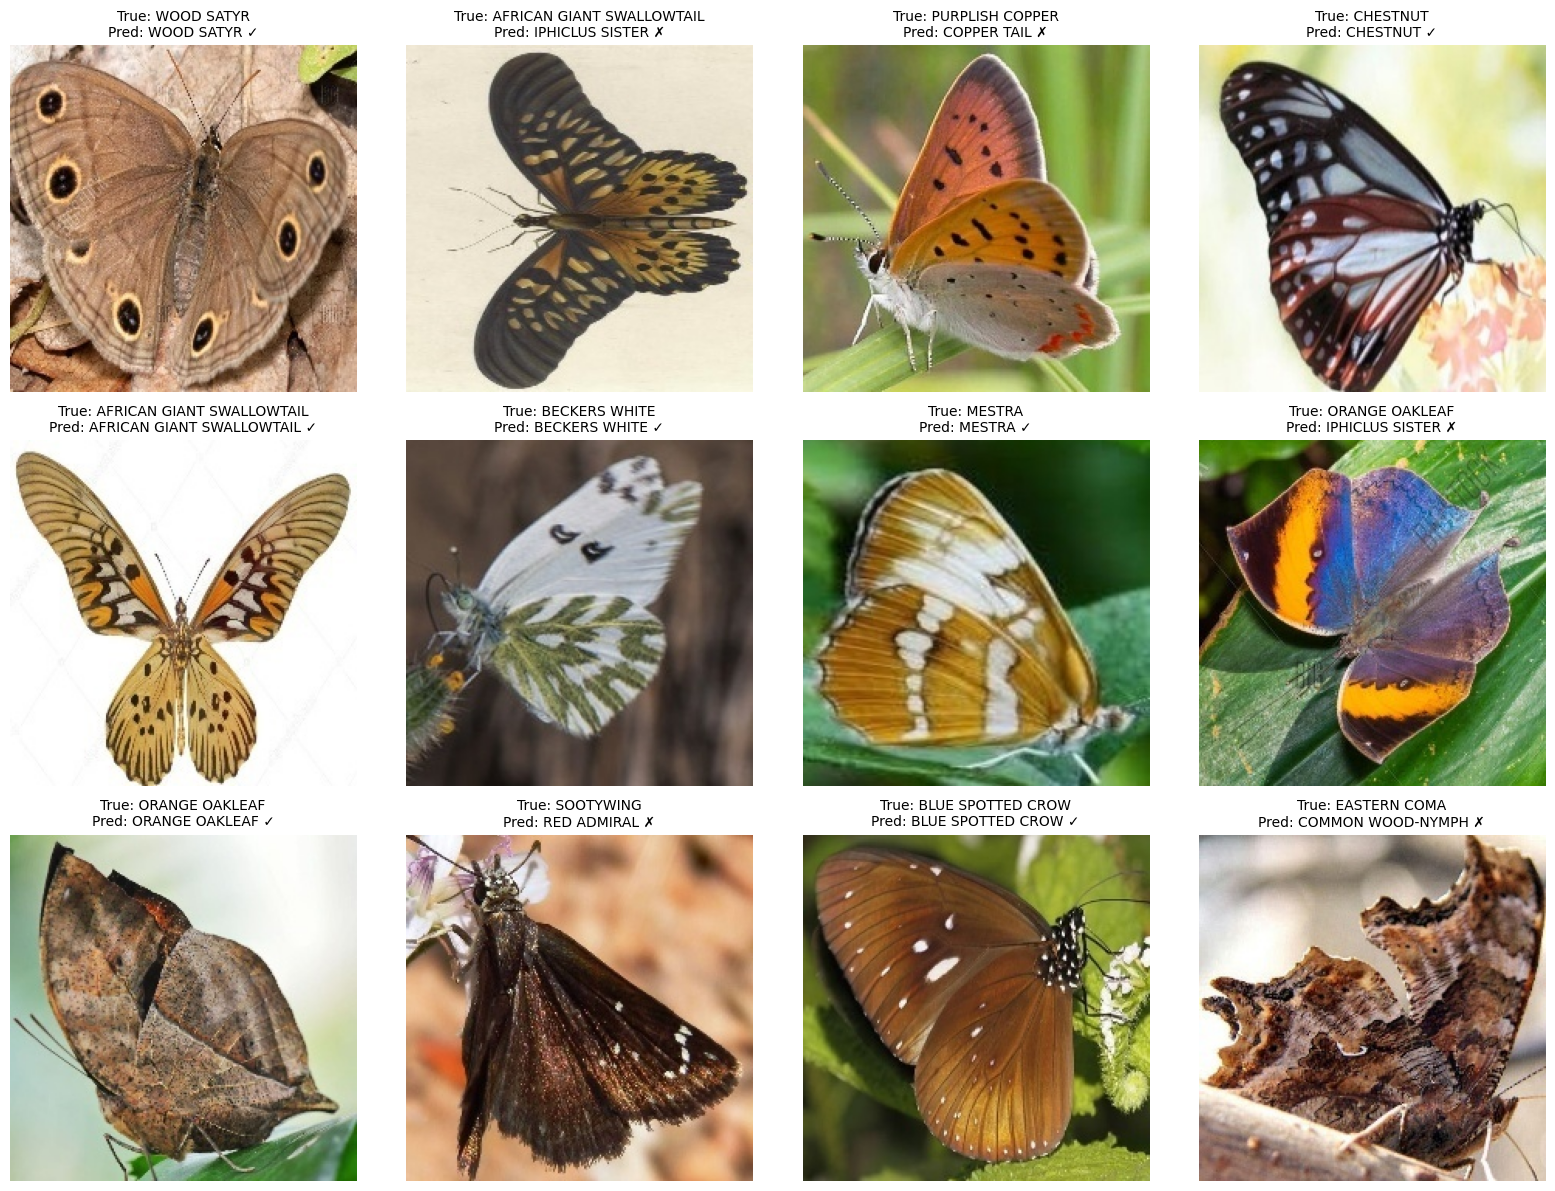

In [23]:
import matplotlib.pyplot as plt
import os

N = 12
plt.figure(figsize=(16, 12))

for i in range(N):
    row = val_df_split.iloc[i]
    img_path = os.path.join(TRAIN_DIR, row["filename"])
    img = plt.imread(img_path)
    
    true_label = row["class"]
    pred_label = val_pred_labels[i]
    
    correct = (pred_label == true_label)
    mark = "✓" if correct else "✗"
    title = f"True: {true_label}\nPred: {pred_label} {mark}"
    
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()

## Model Performance

The below plot shows the validation accuracy of our 4 models increase over each epoch.

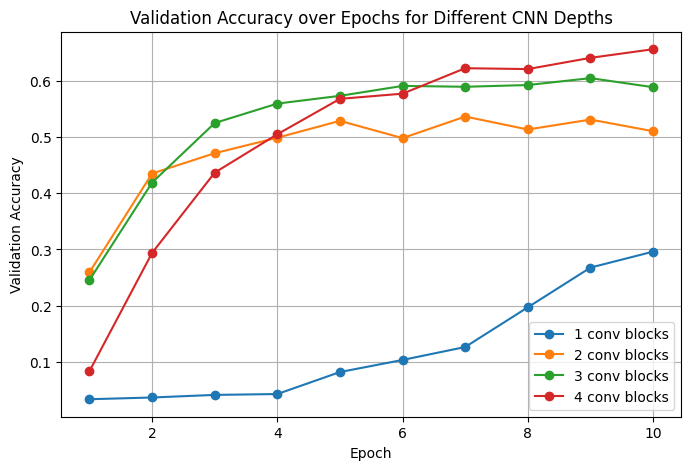

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for d, history in histories.items():
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, marker="o", label=f"{d} conv blocks")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs for Different CNN Depths")
plt.legend()
plt.grid(True)
plt.show()

## Performance Analysis

We can see that validation accuracy increases with the number of epochs. For the most part, each model's accuracy increases at a decreasing rate with each epoch. Interestingly, the top performing model (with 4 convolutional blocks) is outperformed by the simpler models with 2 and 3 convolutional blocks for the first few epochs. By epoch 7, the most complex model outperforms the others, and plateaus around 65% accuracy.